In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import os

plt.rcParams.update({"text.usetex": True, "font.family": "mathpazo"})

In [10]:
from scipy.special import betainc
from scipy.stats import beta

def alpha_star(n, delta, alpha):
    astar = alpha - np.sqrt(-np.log(delta)/(2*n))
    k = np.floor((n+1)*astar)
    return np.where( k > 0, astar, np.nan)

def alpha_star_vovk2b(n, delta, alpha):
    if isinstance(n, np.ndarray):
        n = n[None,:]
    if isinstance(alpha, np.ndarray):
        alpha = alpha[None,:]
    if isinstance(delta, np.ndarray):
        delta = delta[None,:]

    alpha_stars = np.linspace(0, alpha, 100)[:,None] # [100, 1]
    v = np.floor((n + 1) * alpha_stars - 1) # [100, K]

    delta_thresh = betainc(n-v, 1+v, 1-alpha)
    alpha_stars = np.where(delta_thresh > delta, 0, alpha_stars)
    # guarantee_prob = betaincinv(n - v, 1 + v, delta) # [100, K]
    # alpha_stars = np.where(guarantee_prob > 1 - alpha, 0, alpha_stars)
    alpha_stars = alpha_stars.max(axis=0)
    if isinstance(n, np.ndarray):
        n = n[0,:]
    k = np.floor((n+1)*alpha_stars)
    return np.where( k > 0, alpha_stars, np.nan)

def _bound_on_Ez(k, n: int):
    exp_term = np.exp(
        1.0 / (12 * n - 12) - 1.0 / (12 * k - 11) - 1.0 / (12 * n - 12 * k + 1)
    )
    return n * np.sqrt((n - 1) / (2 * np.pi) / (k - 1) / (n - k)) * exp_term

def _exact_bound_on_Ez(k, n:int):
    a = (k-1) / (n-1)
    return beta.pdf(a,k,n-k+1)


def kl_bound(alpha_hat, n, alpha, delta):
    k = np.floor(alpha_hat * (n + 1))
    a = (k - 1) / (n - 1)
    a[a >= 1.] = np.nan
    a[a <= 0.] = np.nan
    binary_kl = a * np.log(a / alpha) + (1 - a) * np.log((1 - a) / (1 - alpha))
    return (n - 1) * binary_kl - np.log(_exact_bound_on_Ez(k, n) / delta)

def plot_kl_budget_vs_n(ax: Axes, alpha, delta):
    ns = np.concatenate([np.linspace(10,50,100), np.logspace(np.log10(50), np.log10(200000), 100, base=10)])
    alpha_hats = np.concatenate([np.logspace(-5,-2,100,base=10),np.linspace(0.01,alpha, 100)])

    Ns, AlphaHats = np.meshgrid(ns, alpha_hats)
    KLBounds = kl_bound(AlphaHats,Ns, alpha, delta)

    cmap = sns.color_palette("crest_r", as_cmap=True)
    cmap.set_bad('#aaaaaa')
    levels = [0,1,2,5,10,20,50,100,200,500,1000,2000,5000]

    cs = ax.contourf(np.log10(Ns), AlphaHats, KLBounds, cmap=cmap, levels=levels, norm="log", extend='both')

    cs2 = ax.contour(np.log10(Ns), AlphaHats, KLBounds, cmap=cmap, norm="log", levels=levels, extend='both')
    tick_values = [50,500,5000,50000]
    ax.set_xticks(np.log10(tick_values),[f"{v:.0e}" for v in tick_values])

    ax.plot(np.log10(ns), alpha_star(ns, delta, alpha), label="Vovk Prop 2a", color='C1', linestyle=':')
    ax.plot(np.log10(ns), alpha_star_vovk2b(ns, delta, alpha), label="Vovk Prop 2b", color='C1', linestyle="-.")

    ax.set_xlabel("Calibration Set Size")
    ax.set_ylabel(r"Empirical Miscoverate Rate $\hat{\alpha}$")
    ax.set_title(fr"Target $\alpha={alpha:0.2f}$, $\delta={delta:0.2f}$")
    ax.fill_between(np.log10(ns),2./(ns+1)+0.2,facecolor='#aaaaaa', zorder=-2)
    ax.legend(loc='upper left',ncols=1)
    ax.set_ylim([0,alpha])
    ax.clabel(cs2, fmt='%2d', colors='w', fontsize=9)

    return cs


def plot_kl_budget_vs_delta(ax: Axes, alpha, N):
    alpha_hats = alpha_hats = np.concatenate([np.logspace(-5,-2,50,base=10),np.linspace(0.01,alpha, 100)])
    deltas = np.logspace(np.log10(5e-5),np.log10(0.5), base=10)

    Deltas, AlphaHats = np.meshgrid(deltas, alpha_hats)
    KLBounds = kl_bound(AlphaHats,N, alpha,Deltas)

    cmap = sns.color_palette("crest_r", as_cmap=True)
    cmap.set_bad('#aaaaaa')
    levels = [0,1,2,5,10,20,50,100,200,500,1000,2000,5000]
    cs = ax.contourf(np.log10(Deltas), AlphaHats, KLBounds, cmap=cmap, levels=levels, norm="log", extend='both')

    cs2 = ax.contour(np.log10(Deltas), AlphaHats, KLBounds, cmap=cmap, norm="log", levels=levels, extend='both')
    tick_values = [5e-5,5e-4,5e-3,5e-2,5e-1]
    ax.set_xticks(np.log10(tick_values),[f"{v:.0e}" for v in tick_values])

    ax.plot(np.log10(deltas), alpha_star(N, deltas, alpha), label="Vovk Prob 2a", color='C1', linestyle=':')
    ax.plot(np.log10(deltas), alpha_star_vovk2b(N, deltas, alpha), label="Vovk Prop 2b", color='C1', linestyle="-.")

    ax.set_xlabel("Delta")
    ax.set_title(fr"Target $\alpha={alpha:0.2f}$, $N={N}$")
    ax.fill_between(np.log10(deltas),2./(N+1)*np.ones_like(deltas)+0.2,facecolor='#aaaaaa', label="Cannot provide guarantee", zorder=-1)
    ax.set_ylim([0,alpha])
    ax.clabel(cs2, fmt='%2d', colors='w', fontsize=9)

    return cs


In [3]:
FIGURES_ROOT = "figures/theory/"
os.makedirs(FIGURES_ROOT, exist_ok=True)

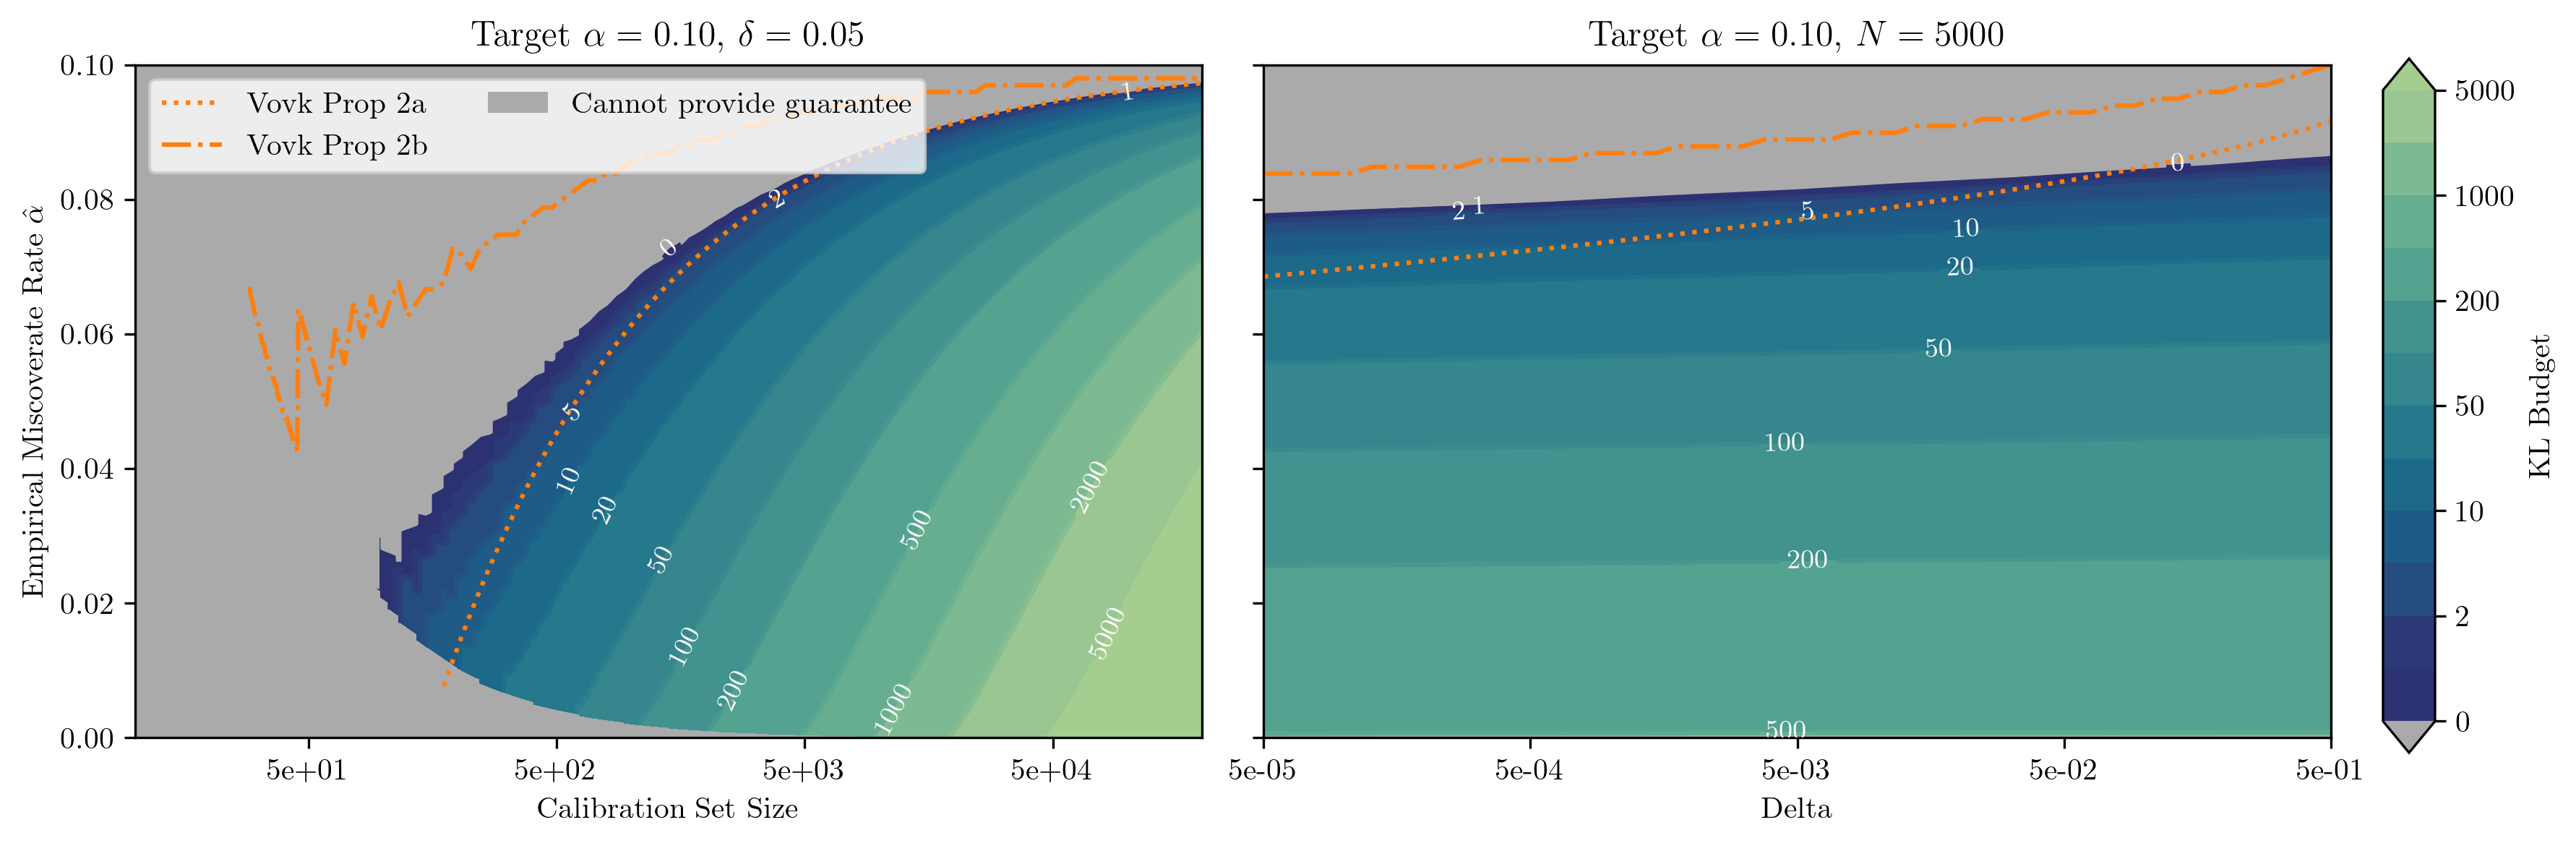

In [5]:
fig, axes = plt.subplots(1,2,sharey='row', figsize=[12,4], dpi=300)
cs = plot_kl_budget_vs_n(axes[0],0.1,0.05)
plot_kl_budget_vs_delta(axes[1],0.1,5000)
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92,0.12, 0.02,0.8])
fig.colorbar(cs, cax=cbar_ax, label="KL Budget")
plt.savefig(os.path.join(FIGURES_ROOT,"summary.pdf"))

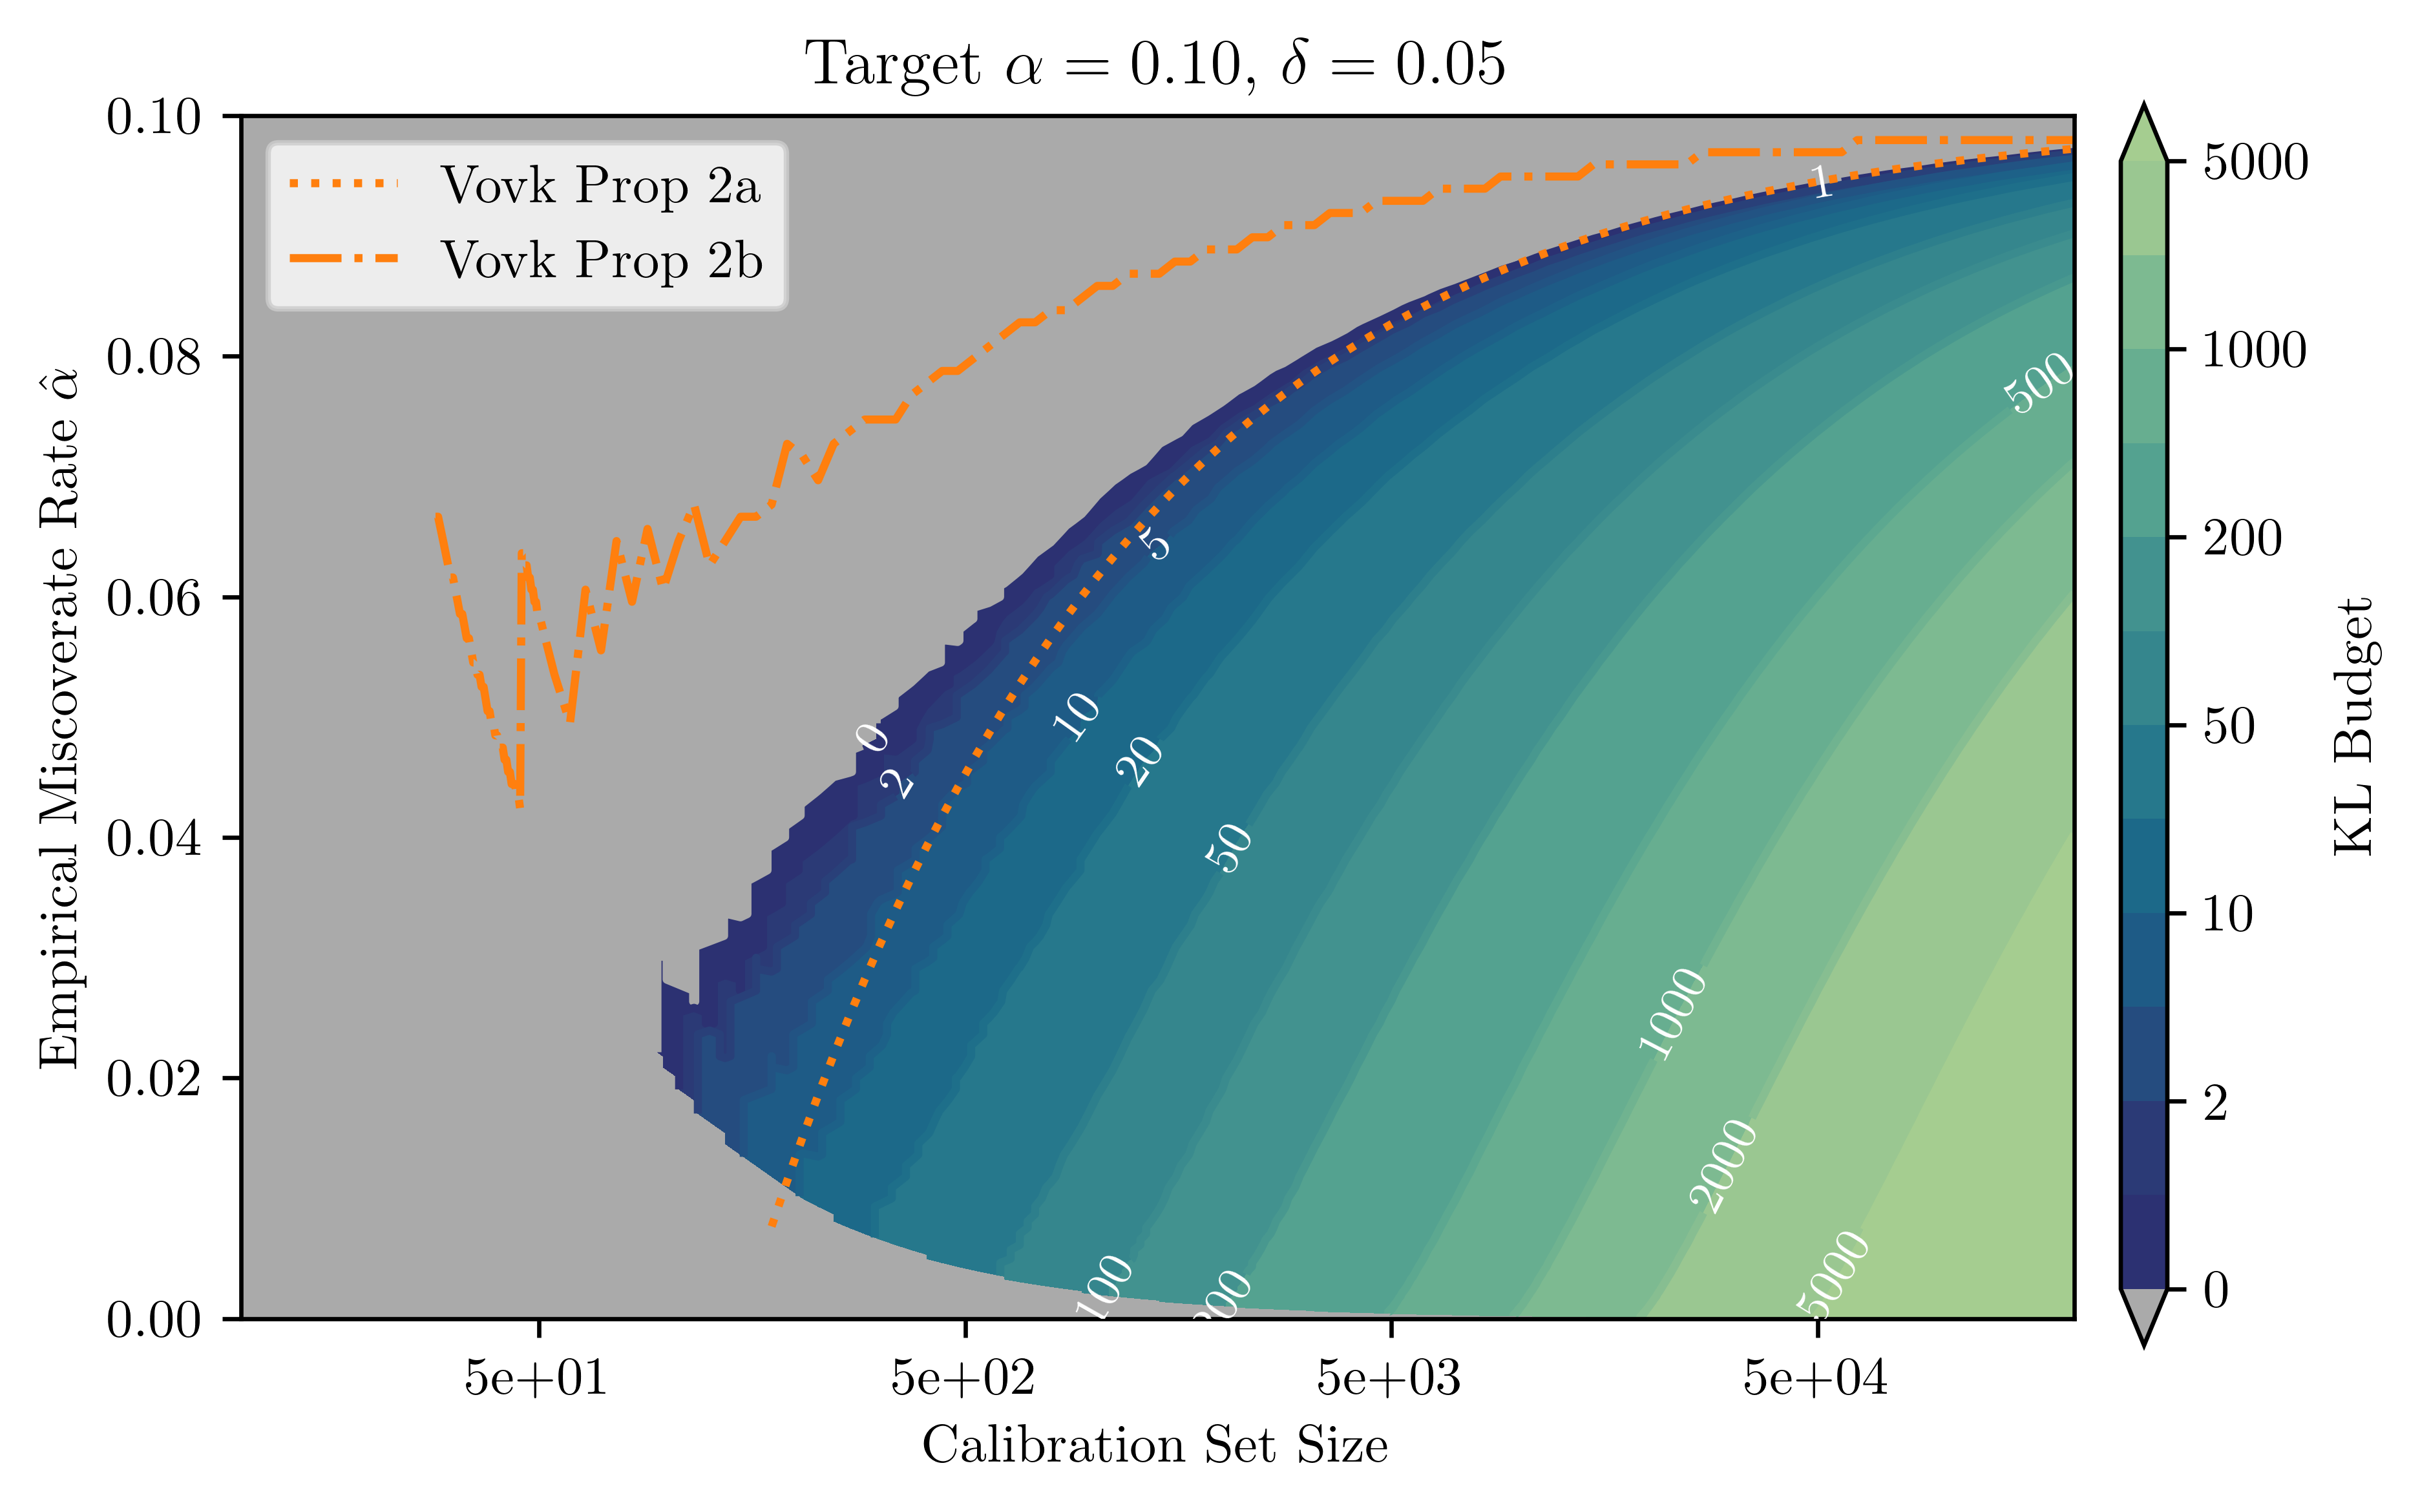

In [13]:
fig, axes = plt.subplots(1,1,figsize=[6,4], dpi=600)
cs = plot_kl_budget_vs_n(axes,0.1,0.05)
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92,0.12, 0.02,0.8])
fig.colorbar(cs, cax=cbar_ax, label="KL Budget")